## Zarr DataLoader

In [24]:
import os
import glob
import natsort
import xarray as xr

import sys
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append('../')
from data.healpix import *
from utils.plot import plot_all_chunks

The main goal of this Notebook is to create a Datasets and DataLoader that manipulate Zarr and its associated chunks. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

## Import data

In [26]:
def prepare_paths(path_dir):

    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")
    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output

base_dir = "/mnt/disk/dataset/sentinel-ai-processor"
version = "V4"

TRAIN_DIR = f"{base_dir}/{version}/train/"
VAL_DIR = f"{base_dir}/{version}/val/"
TEST_DIR = f"{base_dir}/{version}/train/"
df_train_input, df_train_output =  prepare_paths(TRAIN_DIR)
df_val_input, df_val_output =  prepare_paths(VAL_DIR)
df_test_input, df_test_output =  prepare_paths(TEST_DIR)

In [13]:
zarr_index = 3

In [27]:
# open .zarr datatree
x_path = df_train_output["path"].iloc[zarr_index] + ".zarr"
dt = xr.open_datatree(x_path, engine="zarr", chunks={}, decode_times=False)

In [29]:
dt.measurements.reflectance.r60m

<xarray.DataTree 'r60m'>
Group: /measurements/reflectance/r60m
    Dimensions:  (y_60m: 1830, x_60m: 1830)
    Coordinates:
        x        (x_60m) float32 7kB dask.array<chunksize=(305,), meta=np.ndarray>
        y        (y_60m) float32 7kB dask.array<chunksize=(305,), meta=np.ndarray>
    Dimensions without coordinates: y_60m, x_60m
    Data variables:
        b01      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b02      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b03      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b04      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b05      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b06      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b07      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b09      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b11      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b12      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
        b8a      (y_60m, x_60m) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>

## Plot all chunks for a given resolution

In [30]:
res = "60m"
bands = get_bands(data_tree=dt, res=res)
bands

['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b09', 'b11', 'b12', 'b8a']

In [35]:
1830/60

30.5

In [34]:
chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=bands[0], res=res)
chunk_size_y

305

In [20]:
for band in bands:
    plot_all_chunks(dt  , band, res, chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x, save=True, filename=band ,  cmap="viridis", verbose= False, figsize_scale=3)

## Extract Chunk from Xarray

In [21]:
chunk_y_idx = 4
chunk_x_idx = 4
chunk = get_chunk(data_tree=dt, res=res,
                  chunk_y_idx=chunk_y_idx, chunk_x_idx=chunk_x_idx,
                  chunk_size_y=chunk_size_y, chunk_size_x=chunk_size_x)

chunk_array = chunk.to_dataset().to_dataarray()
chunk_array

<xarray.DataArray (variable: 11, y_60m: 305, x_60m: 305)> Size: 8MB
dask.array<stack, shape=(11, 305, 305), dtype=float64, chunksize=(1, 305, 305), chunktype=numpy.ndarray>
Coordinates:
    x         (x_60m) float32 1kB dask.array<chunksize=(305,), meta=np.ndarray>
    y         (y_60m) float32 1kB dask.array<chunksize=(305,), meta=np.ndarray>
  * variable  (variable) object 88B 'b01' 'b02' 'b03' ... 'b11' 'b12' 'b8a'
Dimensions without coordinates: y_60m, x_60m

## Datasets & DataLoaders

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np


def normalize(data_array):
    """
    Normalize the data array to the range [0, 1].
    """
    normalized_data = []
    valid_masks= []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        result = band_data.copy().astype(np.float32)
        # result[valid_mask] = result[valid_mask] / 10000
        # result[valid_mask] = np.clip(result[valid_mask], 0, 1)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks)

class Sentinel2ZarrDataset(Dataset):
    def __init__(self, df_x, res, bands, target_size=(320, 320)):
        self.df_x = df_x
        self.res = res
        self.bands = bands
        self.target_size = target_size
        self.res_key = f"r{res}"
        self.x_res = f"x_{res}"
        self.y_res = f"y_{res}"

    def __len__(self):
        return len(self.df_x)

    def __getitem__(self, index):
        zarr_path = self.df_x["path"].iloc[index] + ".zarr"
        datatree = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False, chunks={})
        data = datatree.measurements.reflectance[self.res_key]
        data = data.to_dataset()
        data = data[self.bands].to_dataarray()

        # --- Get chunk layout ---
        band  = self.bands[0]
        chunk_size_y = data.chunksizes[self.y_res][0]
        chunk_size_x = data.chunksizes[self.x_res][0]
        nb_chunks_y = len(data.chunksizes[self.y_res])
        nb_chunks_x = len(data.chunksizes[self.x_res])

        all_chunks, all_masks = [], []

        for row in range(nb_chunks_y):  # Y direction
            for col in range(nb_chunks_x):  # X direction
                y_start = row * chunk_size_y
                x_start = col * chunk_size_x
                chunk_ds = data.isel(
                            {self.y_res: slice(y_start, y_start + chunk_size_y),
                            self.x_res: slice(x_start, x_start + chunk_size_x)}
                        )

                chunk_array = chunk_ds.values.astype(np.float32)
                chunk_array, mask_array = normalize(chunk_array)
                # logger.debug(f"[{index}] Chunk ({row},{col}) normalized")

                # Convert to torch [C, H, W]
                chunk_tensor = torch.from_numpy(chunk_array).float()
                mask_tensor = torch.from_numpy(mask_array).float()


                all_chunks.append(chunk_tensor)
                all_masks.append(mask_tensor)

        chunks_grid = torch.stack(all_chunks).view(nb_chunks_y, nb_chunks_x, *all_chunks[0].shape)
        masks_grid = torch.stack(all_masks).view(nb_chunks_y, nb_chunks_x, *all_masks[0].shape)
        meta = (nb_chunks_y, nb_chunks_x, chunk_size_y, chunk_size_x)

        datatree.close()
        # logger.debug(f"[{index}] Finished processing -> chunks_grid: {chunks_grid.shape}, masks_grid: {masks_grid.shape}")

        return chunks_grid, masks_grid, meta

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Total batch number is equal to Number of zarr * nb_chunks_x * nb_chunks_y

example: 
 - 60m resolution
 - nb_chunks_x = 6 
 - nb_chunks_y = 6 
 - batch_size in train_loader = 2

final batch = batch_size* nb_chunks_x * nb_chunks_y * = 72

Final ouput ->>>>  [72, 11, 305, 305]

## Check data 

Let's take a random index in the entire dataset. batch = len of dataset

In [17]:
from tqdm import tqdm
import torch

# --------- Parameters ----------
res = "60m"
bands = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b09', 'b11', 'b12', 'b8a']
batch_size = 2

train_dataset = Sentinel2ZarrDataset(df_x=df_test_output, res=res, bands=bands)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cuda" if torch.cuda.is_available() else "cpu"
with tqdm(total=len(train_loader.dataset), ncols=100, colour='#3eedc4') as t:
        t.set_description("Training")
        for batch_idx, (chunks_grid, masks_grid, meta) in enumerate(train_loader):
            B, ny, nx, C, H, W = chunks_grid.shape
            chunks_tensor = chunks_grid.view(B*ny*nx, C, H, W).to(device)
            masks_tensor = masks_grid.view(B*ny*nx, C, H, W).to(device)
            # t.update(masks_tensor.size(0))
            t.update(B)

Training: 100%|███████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


In [18]:
print(f"Final output shape {chunks_tensor.shape} - [B, C, H, W]")

Final output shape torch.Size([72, 11, 305, 305]) - [B, C, H, W]


# Batch Verification

In [19]:
import matplotlib.pyplot as plt

Training:   0%|                                                              | 0/10 [00:00<?, ?it/s]

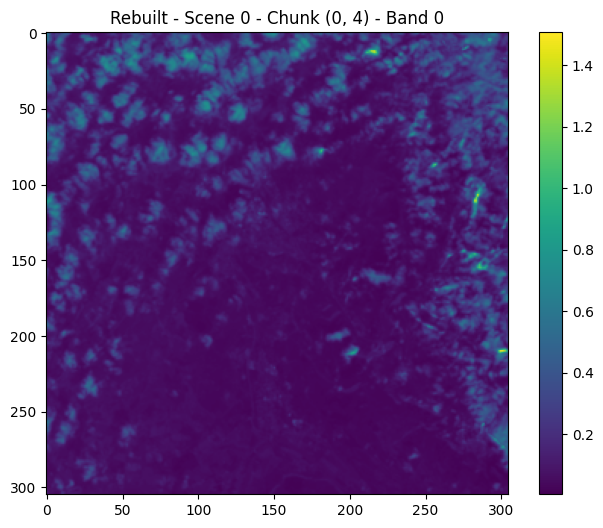

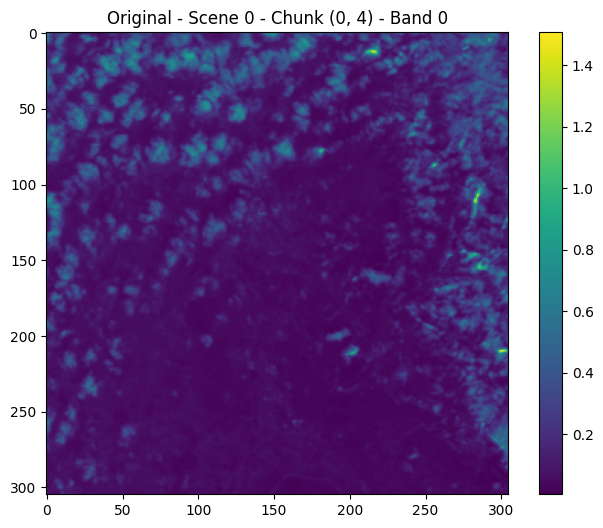

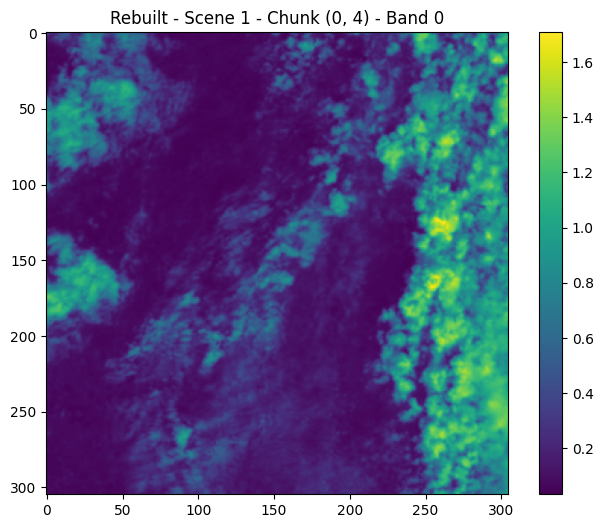

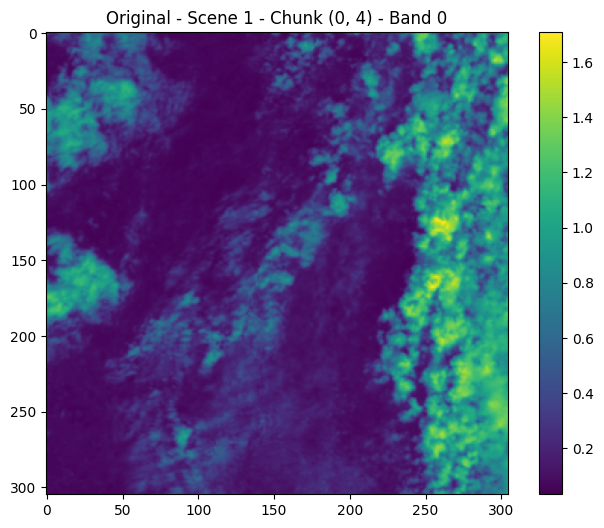

Training:  20%|██████████▊                                           | 2/10 [00:04<00:17,  2.20s/it]

##################################################


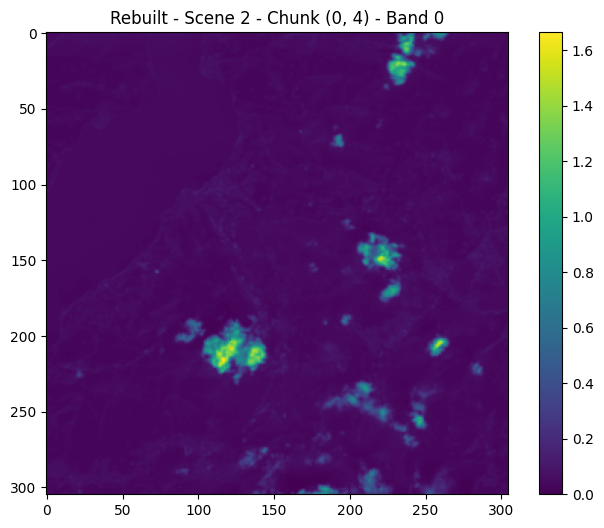

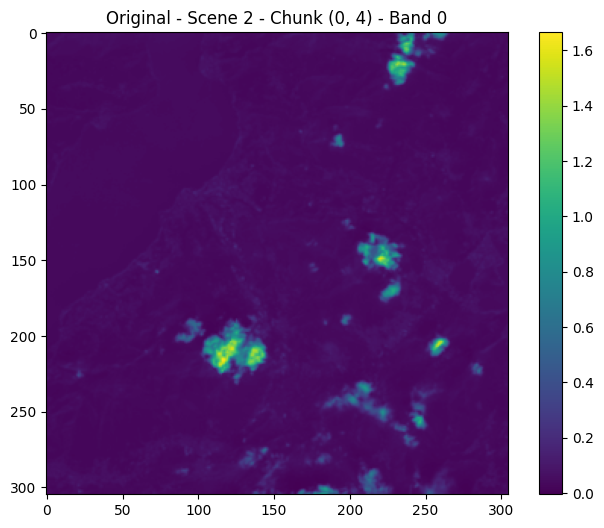

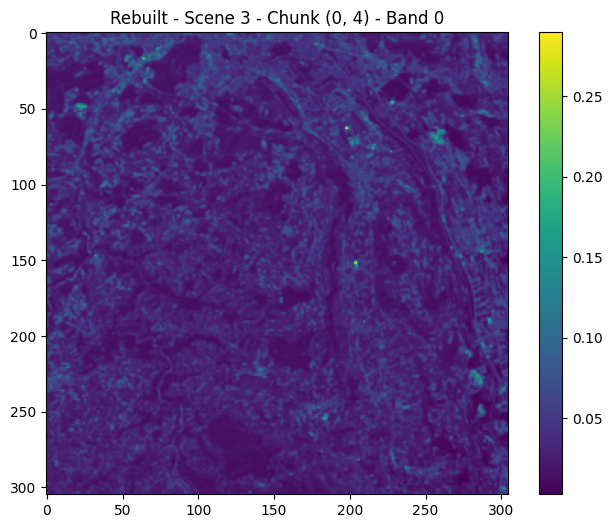

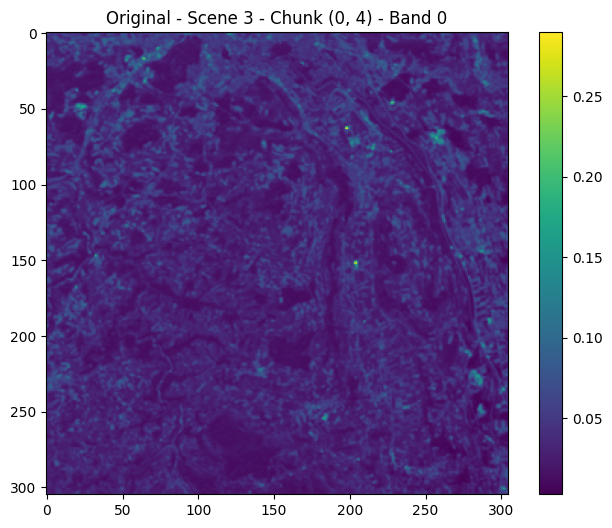

Training:  40%|█████████████████████▌                                | 4/10 [00:08<00:12,  2.13s/it]

##################################################


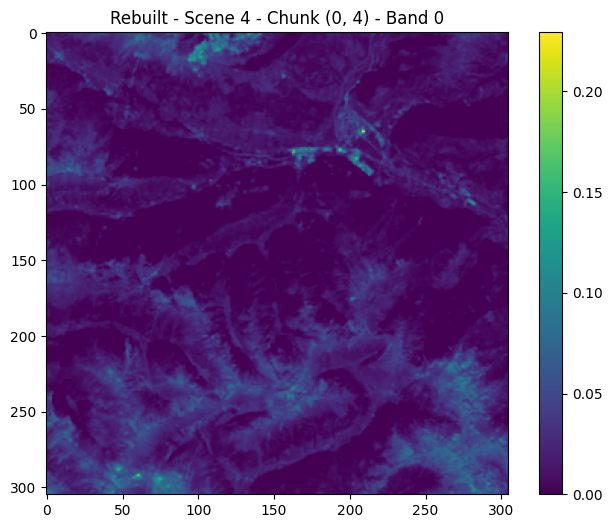

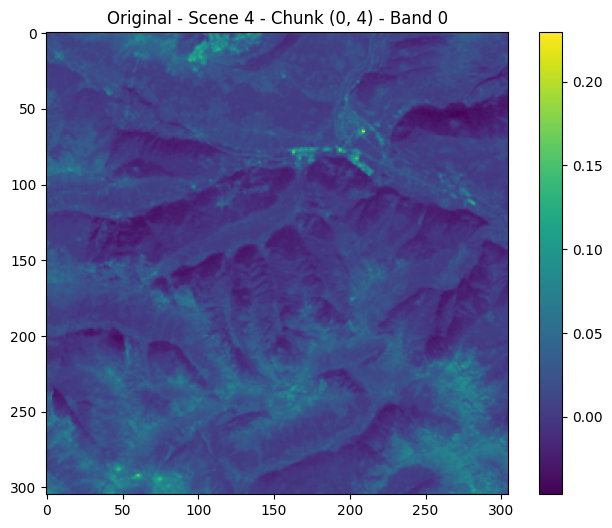

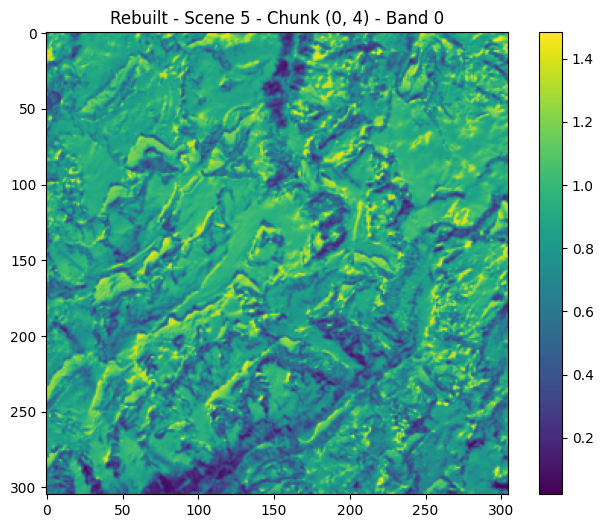

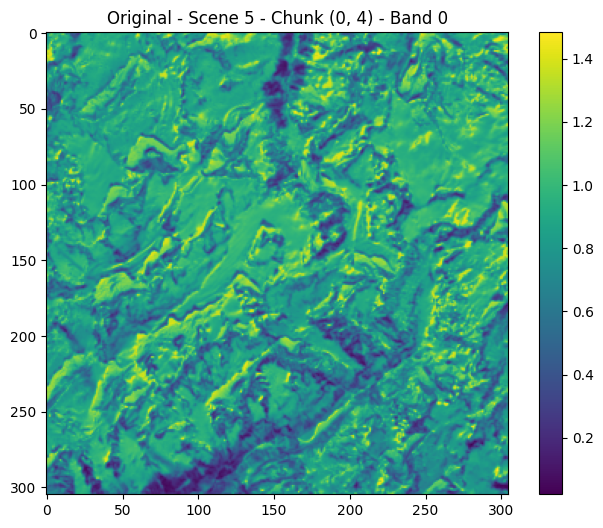

Training:  60%|████████████████████████████████▍                     | 6/10 [00:13<00:08,  2.20s/it]

##################################################


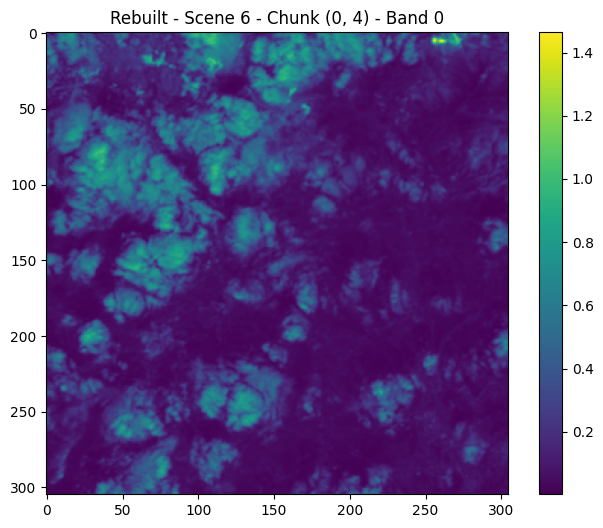

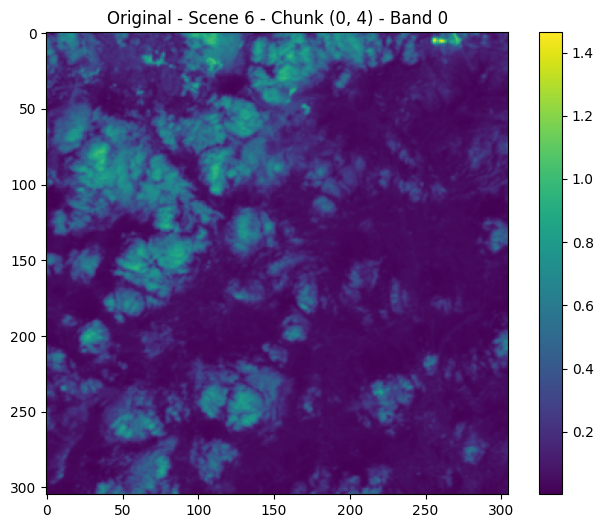

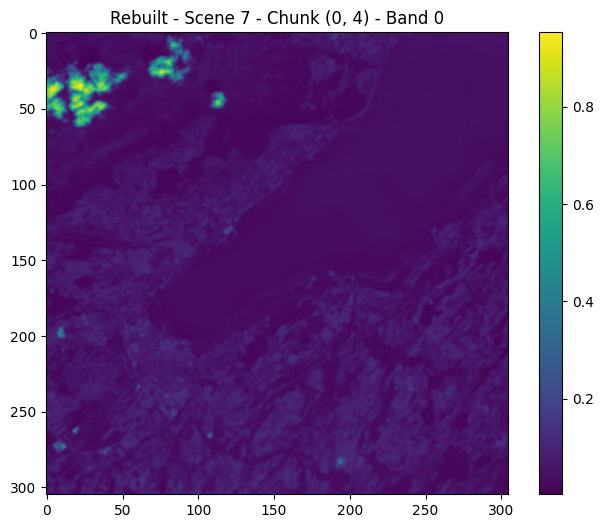

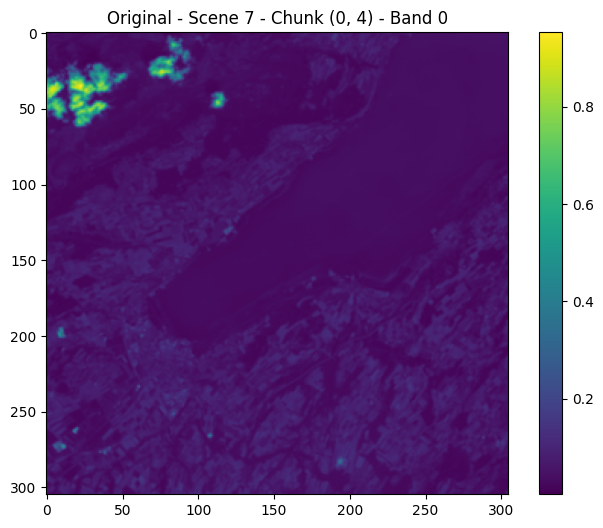

Training:  80%|███████████████████████████████████████████▏          | 8/10 [00:17<00:04,  2.21s/it]

##################################################


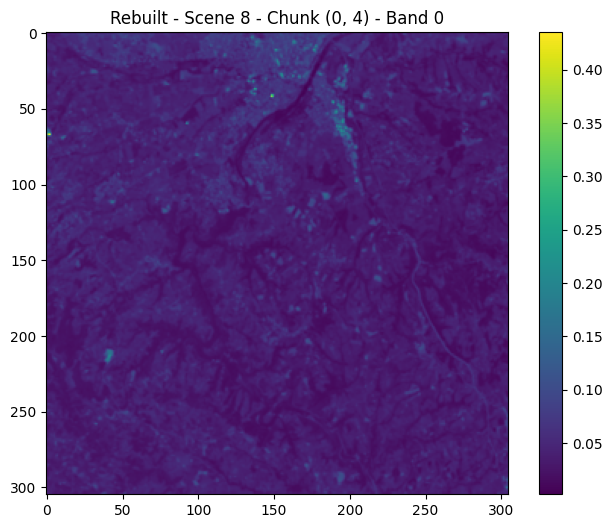

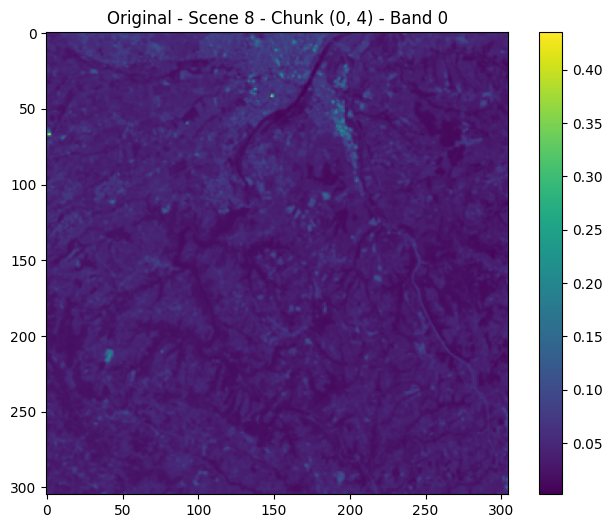

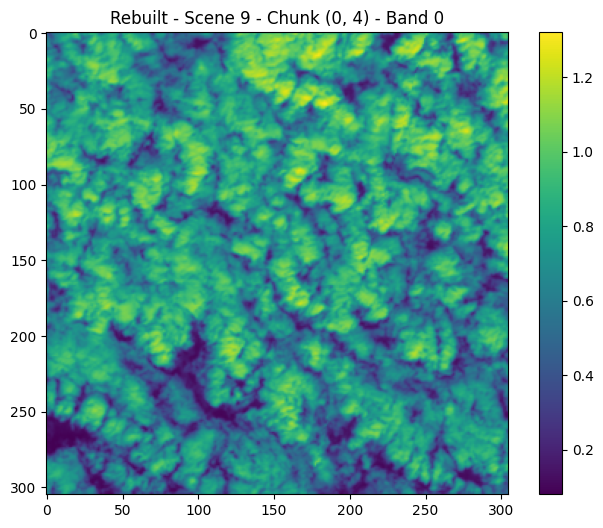

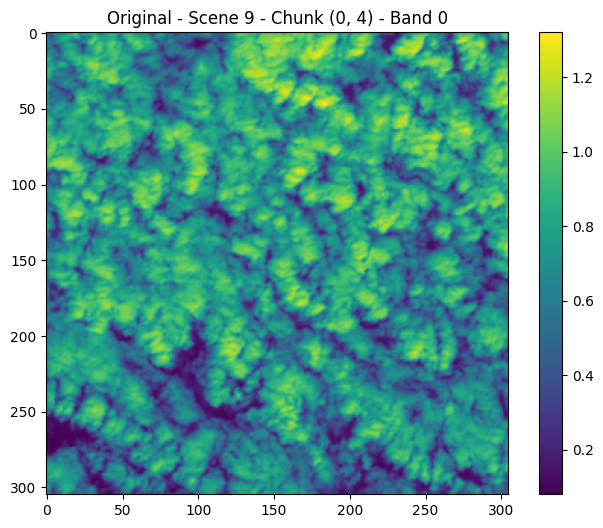

Training: 100%|█████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]

##################################################


In [24]:
res = "60m"
bands = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b09', 'b11', 'b12', 'b8a']
df_test_input, df_test_output =  prepare_paths(TEST_DIR)
batch_size = len(df_test_output[:2])
train_dataset = Sentinel2ZarrDataset(df_x=df_test_output[:2], res=res, bands=bands)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cuda" if torch.cuda.is_available() else "cpu"

with tqdm(total=len(train_loader.dataset), ncols=100, colour='#3eedc4') as t:
    t.set_description("Training")

    for batch_idx, (chunks_grid, masks_grid, meta) in enumerate(train_loader):
        # chunks_grid: [B, nb_chunks_y, nb_chunks_x, C, H, W]
        B, ny, nx, C, H, W = chunks_grid.shape
        chunks_tensor = chunks_grid.view(B * ny * nx, C, H, W).to(device)

        # Loop over each scene in the batch
        for batch_scene in range(B):
            scene_index = batch_idx * batch_size + batch_scene
            scene_chunks = chunks_grid[batch_scene]  # [ny, nx, C, H, W]

            # Pick a position in the chunk grid
            row_idx = 0
            col_idx = 4

            # Get rebuilt chunk from dataset tensor
            rebuilt_chunk = scene_chunks[row_idx, col_idx]  # [C, H, W]

            # Load same chunk directly from Zarr
            x_path = df_test_output["path"].iloc[scene_index] + ".zarr"
            dt = xr.open_datatree(x_path, engine="zarr", mask_and_scale=False, chunks={})
            data_tree = dt.measurements.reflectance[f"r{res}"]

            # Compute pixel indices in full image
            chunk_size_y = H
            chunk_size_x = W
            y_start = row_idx * chunk_size_y
            x_start = col_idx * chunk_size_x

            original_chunk = data_tree.isel(
                {f"y_{res}": slice(y_start, y_start + chunk_size_y),
                 f"x_{res}": slice(x_start, x_start + chunk_size_x)}
            ).to_dataset().to_dataarray()

            # --- Plot rebuilt ---
            plt.figure(figsize=(8, 6))
            plt.imshow(rebuilt_chunk[0].cpu().numpy(), cmap="viridis")
            plt.title(f"Rebuilt - Scene {scene_index} - Chunk ({row_idx}, {col_idx}) - Band 0")
            plt.colorbar()
            plt.show()

            # --- Plot original ---
            plt.figure(figsize=(8, 6))
            plt.imshow(original_chunk[0].values, cmap="viridis")
            plt.title(f"Original - Scene {scene_index} - Chunk ({row_idx}, {col_idx}) - Band 0")
            plt.colorbar()
            plt.show()
        print(50*"#")
        t.update(B)